<a href="https://colab.research.google.com/github/nuvvulapraveen17/MachineLearning-DeepLearning/blob/main/WordEmbeddings/WordEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note:** I wrote this Notebook to enrich my understanding of **Natural Language Processing(NLP) with Deep Learning** from the NLP Specialization course from Coursera.

<h4><b>Continous bag of words(CBOW) model is implemented without using any frameworks from scratch.</b></h4>

# 0.Word Embeddings

When we have a text kind of data(input) and want to learn/represent a mathematical function or machine learning algorithm, we need to convert this textual data into numeric form of vector $x$. The mathematical function can be Sentiment Analysis or Neural Machine Translation(NMT) etc..

We first need a way of converting the
input to a vector $x$.

* Let's say we have a corpus, consider the set <b>V</b>
of all unique words across all input
streams (i.e., all sentences or documents)
* We need a representation for every
word in <b>V</b>

* One very simple way of doing this is
to use **one-hot vectors** of size Vocabulary(<b>|V|</b>). But these are sparse, memory consuming and don't have the notion of capturing the similarity between words.

**Distributed Representations of words**

* You shall know a word by the company it keeps - Firth, J. R. 1957:11.

  From the above people started learning Distributional based representations, which leads to word vectors.

* Most famous Word Embeddings are
  1.   **Word2Vec(Google)**
  2.   **Glove(Stanford)**
  3.   **FastText(Facebook)**

  There are more sophisticated/advanced models based on contextual embeddings.
  4.   **BERT(Google)**
  5.   **ELMO(Allen Institute of AI)**
  6.   **GPT-2(Open AI)**

  Contextual Embeddings uses advanced deep neural network arcitectures to refine the representations of word's meaning according to their contexts.

  **In Word Embedding models given a word will always has the same embedding. Where as in contextual embeddings words have different embeddings depending on their contexts.**

In This Notebook we will learn **CBOW**, which is a type of **Word2Vec** model.



# 1.The Continuous bag of words model

Let's take a look at the following sentence:

    > 'I am happy because I am learning'.

* In continuous bag of words (CBOW) modeling, we try to predict the center word given a few context words (the words around the center word).
* For example, if we were to choose a context half-size of say  C=2(Which is a **hyperparameter** to our model), then you would try to predict the word happy given the context that includes 2 words before and 2 words after the center word:

> C  words before: [I, am] <br> C  words after: [because, I]

* In other words:

    *   <center>$context=[I,am,because,I]$</center>
    *   <center>$target=happy$</center>

The structure of your model will look like this
![](https://raw.githubusercontent.com/nuvvulapraveen17/MachineLearning-DeepLearning/main/WordEmbeddings/image1.png)
Figure1

Where $\bar{x}$ is the average of all the one hot vectors of the context words.

![](https://raw.githubusercontent.com/nuvvulapraveen17/MachineLearning-DeepLearning/main/WordEmbeddings/image2.png)
Figure 2

Once we have encoded all the context words, we can use $\bar{x}$ as the input to your model.

The architecture you will be implementing is as follows:

*   <center>$h = W_1X + b_1$</center>
*   <center>$a = ReLU(h)$</center>
*   <center>$z = W_2a + b_2$</center>
*   <center>$\hat{y} = softmax(z)$</center>

# 2.Data Preparation

Data preparation, which is the first step of any machine learning algorithm. It is a very important step because models are only as good as the data they are trained on and the models used require the data to have a particular structure to process it properly.

In the data preparation phase, starting with a corpus of text, we will:

* Clean and tokenize the corpus.

* Extract the pairs of context words and center word that will make up the training data set for the CBOW model. The context words are the features that will be fed into the model, and the center words are the target values that the model will learn to predict.

* Create simple vector representations of the context words (features) and center words (targets) that can be used by the neural network of the CBOW model.

**Note:** We use shakesphere.txt file as data(Corpus) to ur model.
It's not big data(corpus), but for understanding purpose its sufficient to learn word embeddings.

**2.1 cleaning and Tokenization**, For tokenization we use NLTK library.
* The process of tokenization varies from application to application.

  **e.g:** In the case of **Sentiment Analysis**, we don't need to worry about full stop, comma, etc. In contrast, in the case of **NMT**, we also need to take care of full stop, comma; otherwise, when our **NMT** model tries to predict, it won't place any comma or full stops in the translated text, which is wired for a user to understand the whole meaning of the sentence.

In [1]:
# Import libraries
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from collections import defaultdict
from scipy import linalg

In [2]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [3]:
# we need punkt for tokenizing
# download it to our local directory
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Load, tokenize and pre-process the data
# we regulae expressions(re) module
import re                                                           #  Load the Regex-modul
with open('shakespeare.txt') as f:
    data = f.read()                                                 #  Read in the data

data = re.sub(r'[,!?;-]', '.',data)                                 #  Punktuations are replaced by .

data = nltk.word_tokenize(data)                                     #  Tokenize string to words

data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']    #  Lower case and drop non-alphabetical tokens

print("Number of tokens:", len(data),'\n', data[:15])               #  print data sample

Number of tokens: 60933 
 ['o', 'for', 'a', 'muse', 'of', 'fire', '.', 'that', 'would', 'ascend', 'the', 'brightest', 'heaven', 'of', 'invention']


Lets try to understand our data, what are the most frequently occuring word in the corpus.

In **Glove** model it uses the frequency of co-occurrence of words(co-occurrence matrix) in corpus while learning word embeddings.

In [5]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20) ) # print the 20 most frequent words and their freq.

Size of vocabulary:  5772
Most frequent tokens:  [('.', 9630), ('the', 1521), ('and', 1394), ('i', 1252), ('to', 1159), ('of', 1093), ('my', 857), ('that', 781), ('in', 770), ('you', 748), ('a', 742), ('is', 630), ('not', 559), ('for', 467), ('it', 460), ('with', 441), ('his', 434), ('but', 417), ('me', 417), ('your', 397)]


**2.2 Mapping words to indices and indices to words**

**Note:** Even though we are learning dense representation of words, but still input to our model is **one-hot-vectors**.

To create one-hot word vectors, we can start by mapping each unique word to a unique integer (or index) and back.

In [6]:
def get_dict(data):
    """
    Input:
        data: the data you want to pull (corpus)
    Output:
        word_dict: a dictionary with the weighted probabilities of each word
        word2Ind: returns dictionary mapping the word to its index
        Ind2Word: returns dictionary mapping the index to its word
    """
    
    # we don't need to sort the data in general
    # we use set to get all the unique word in the corpus
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0
    # for each unique word in the corpus/data assign a unique integer.
    word2Ind = {}
    Ind2word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2word[idx] = k
        idx += 1
    return word2Ind, Ind2word

In [7]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5772


In [8]:
# example of word to index mapping
print("Index of the word 'king' :  ",word2Ind['king'] )
print("Word which has index 2743:  ",Ind2word[2743] )

Index of the word 'king' :   2743
Word which has index 2743:   king


In [9]:
def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx

**2.3 Generating training set examples**

Sliding window of words
Now that we have transformed the corpus into a list of clean tokens, we can slide a window of words across this list. For each window we can extract a center word and the context words.

we will use function with yield statement instead of return, so that it acts generator.

yield can be used like the return statement in a function. When done so, the function instead of returning the output, it returns a generator that can be iterated upon. You can then iterate through the generator to extract items.

In [10]:
# Define the 'get_windows' function
def get_windows(words, C):
    # we need to start from i = C as our first center word
    i = C
    while i < len(words) - C:
        # geting the center word
        center_word = words[i]
        context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
        yield context_words, center_word
        i += 1

In [11]:
# lets test our above function on a small corpus(data)
# data = ['i', 'am', 'happy', 'because', 'i', 'am', 'learning']
# Print 'context_words' and 'center_word' for the new corpus with a 'context half-size' of 2
for x, y in get_windows(['i', 'am', 'happy', 'because', 'i', 'am', 'learning'], 2):
    print(f'context_words: {x}        \t center_word: {y}')

context_words: ['i', 'am', 'because', 'i']        	 center_word: happy
context_words: ['am', 'happy', 'i', 'am']        	 center_word: because
context_words: ['happy', 'because', 'am', 'learning']        	 center_word: i


In Above we are able to get our required data, only thing we need to do is transform them to numerical data(one-hot-form).

**The center words will be represented as one-hot vectors, and the vectors that represent context words are also based on one-hot vectors.**

In [12]:
# Define the 'word_to_one_hot_vector' function that will convert a word into its corresponding one-hot vector.
def word_to_one_hot_vector(word, word2Ind, V):
    # lets first create an array with all zeros in it of size same as |V|
    one_hot_vector = np.zeros(V)
    # get the index coreespomding to word using word2Ind dictionary and set it to 1.
    one_hot_vector[word2Ind[word]] = 1
    return one_hot_vector

In [13]:
# Define the 'context_words_to_vector' function 
def context_words_to_vector(context_words, word2Ind, V):
    # in this case we take mean all context words
    context_words_vectors = [word_to_one_hot_vector(w, word2Ind, V) for w in context_words]
    context_words_vectors = np.mean(context_words_vectors, axis=0)
    return context_words_vectors

**2.4 Batch Data generation for training**

Instead of getting one example as in above we need to get a batch of examples at once.

for which we need a batch_size, usually we consider batch_size as powers of :1($2^{0}$), 2($2^{1}$), 4($2^{2}$), 16($2^{3}$), 32($2^{4}$), 64($2^{5}$), 128($2^{6}$), 256($2^{7}$) ...

First we need to get vectors, i.e. (single example: x(context_words_vector), y(center_word_vector)).

so lets define a function **get_vectors** -> which is a generator

It will take data as input and return the center_word_vector and context_word_vector.

**Note:** While training we need have to iterate over dataset multiple times(epochs), so we need to make sure that for generating examples.

We will also write a function(**pack_idx_with_frequency**) to get the one-hot-for context_words(mean)

In [14]:
def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

In [15]:
def get_vectors(data, word2Ind, V, C):
    # takes the data
    i = C
    while True:
        # lets create zero vectors for both centre_word and context_word
        y = np.zeros(V)
        x = np.zeros(V)
        # get the center_word, its index and mark it as 1
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C):i] + data[(i+1):(i+C+1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq/num_ctx_words
        yield x, y
        i += 1
        if i >= len(data):
            print('i is being set to 0')
            i = 0

Now we can write a function to generate a batch of examples using **generate_batches** -> which is a generator.

we get individual examples and append them to batch_x and batch_y till its size equals to batch_size use yield as return which makes the function as generator.

In [16]:
def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        while len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch = []

# 3.Training the Model

**3.1 Initializing the model**

we will now initialize two matrices and two vectors.

* The first matrix ($W_1$) is of dimension $N \times V$, where $V$ is the number of words in your vocabulary and $N$ is the dimension of your word vector.

* The second matrix ($W_2$) is of dimension $V \times N$.

* Vector $b_1$ has dimensions $N \times 1$.
* Vector $b_2$ has dimensions $V \times 1$.
* $b_1$ and $b_2$ are the bias vectors of the linear layers from matrices $W_1$ and $W_2$.

The overall structure of the model will look as in Figure 1, but at this stage we are just initializing the parameters.

In [17]:
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    np.random.seed(random_seed)

    # W1 has shape (N,V)
    W1 = np.random.rand(N,V)
    # W2 has shape (V,N)
    W2 = np.random.rand(V,N)
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)

    return W1, W2, b1, b2

**3.2 Softmax function**

we need to implement the softmax function at the output layer.

<br>

  *   <center>$softmax(z_i) = \frac{e^{z_i}}{\sum_{i=0}^{V-1}e^{z_i}}$</center>

In [18]:
def softmax(z):
    '''
    Inputs: 
        z: output scores from the hidden layer
    Outputs: 
        yhat: prediction (estimate of y)
    '''
    
    # Calculate yhat (softmax)
    e_z = np.exp(z)
    yhat = e_z/np.sum(e_z,axis=0)
    
    return yhat

**3.3 Forward Propagation**

values of the hidden layer using the following formulas:

*   <center>$h = W_1X + b_1$</center>
*   <center>$a = ReLU(h)$</center>

Values of the output layer
*   <center>$z = W_2a + b_2$</center>
*   <center>$\hat{y} = softmax(z)$</center>

We will use as activation the Rectified Linear Unit (ReLU) given by:

*   <center>$f(h) = max(0, h)$</center>

In [19]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    # Calculate h
    h = np.dot(W1,x)+b1
    
    # Apply the relu on h (store result in h)
    h = np.maximum(0,h)
    
    # Calculate z
    z = np.dot(W2,h)+b2
    
    return z, h

**3.4 Cost/loss function**

We will use cross-entropy as loss function because its a semi-superviser learning with classification.

<center>$J = -\sum_{k=1}^{V}y_klog(\hat{y_k})$</center>

In [20]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

**3.5 Training the Model - Backpropagation**

Here i am only presenting the end results of backprop, for better understanding of how to arrive this you can refer any refernec on backpropagation algorithm(I prefer/suggest NPTEL lec from IIT Madras [Deep Learning](https://youtube.com/playlist?list=PLyqSpQzTE6M9gCgajvQbc68Hk_JKGBAYT).

We need to update $W_1, W_2, b_1, b_2$ so we need to compute gradients of them on costfunction $J$.

*   $\frac{\partial J_{batch}}{\partial W_1} = \frac{1}{m}ReLU(W_2^\top(\hat{Y}-Y))X^\top$

*   $\frac{\partial J_{batch}}{\partial W_2} = \frac{1}{m}(\hat{Y}-Y)$

*   $\frac{\partial J_{batch}}{\partial b_1} = \frac{1}{m}ReLU(W_2^\top(\hat{Y}-Y))1_m^\top$


*   $\frac{\partial J_{batch}}{\partial b_2} = \frac{1}{m}(\hat{Y}-Y)1_m^\top$


Where $m$ is the batch_size.

$1_m$ is a row vector with all ones of size $m$: $[1, 1, ..., 1]_m$

In [21]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    
    # Compute l1 as W2^T (Yhat - Y)
    # Re-use it whenever you see W2^T (Yhat - Y) used to compute a gradient
    l1 = np.dot(W2.T,(yhat-y))
    # Apply relu to l1
    l1 = np.maximum(0,l1)
    # Compute the gradient of W1
    grad_W1 = (1/batch_size)*np.dot(l1,x.T)    #1/m * relu(w2.T(yhat-y)) . xT
    # Compute the gradient of W2
    grad_W2 = (1/batch_size)*np.dot(yhat-y,h.T)
    # Compute the gradient of b1
    grad_b1 = np.sum((1/batch_size)*np.dot(l1,x.T),axis=1,keepdims=True)
    # Compute the gradient of b2
    grad_b2 = np.sum((1/batch_size)*np.dot(yhat-y,h.T),axis=1,keepdims=True)
    
    return grad_W1, grad_W2, grad_b1, grad_b2

# 4.Gradient Descent

We have implemented a function to compute the gradients, we will implement batch gradient descent over our training set.

**Hint:** For that, you will use **initialize_model** and the **back_prop** functions which we just created (and the compute_cost function).

we will also print the cost after each batch is processed (**batch size = 128**)

* <b>N</b> is the dimension of Hidden state also becomes the dimension of Word embeddings, it acts as a hyper-parameter to our model.

We will update our weights

*   <center>$W_1 := W_1 - \alpha\frac{\partial J}{\partial W_1}$</center>
*   <center>$W_2 := W_2 - \alpha\frac{\partial J}{\partial W_2}$</center>
*   <center>$b_1 := b_1 - \alpha\frac{\partial J}{\partial b_1}$</center>
*   <center>$b_2 := b_2 - \alpha\frac{\partial J}{\partial b_2}$</center>

In [22]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases   

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
      
        # Get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
        # Get yhat
        yhat = softmax(z)
        # Get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # Update weights and biases
        W1 -= alpha*grad_W1 
        W2 -= alpha*grad_W2
        b1 -= alpha*grad_b1
        b2 -= alpha*grad_b2
        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

**Note:** we will only train for small number of iteartions only, you can try more if you want.

* I have choose the embedding vector size as $N = 50$, so we can increase it further, which scales with computing power.

In [23]:
# test your function
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 0.106936
iters: 20 cost: 0.040204
iters: 30 cost: 0.024862
iters: 40 cost: 0.018015
iters: 50 cost: 0.014132
iters: 60 cost: 0.011629
iters: 70 cost: 0.009881
iters: 80 cost: 0.008591
iters: 90 cost: 0.007599
iters: 100 cost: 0.006813
iters: 110 cost: 0.006357
iters: 120 cost: 0.005978
iters: 130 cost: 0.005641
iters: 140 cost: 0.005340
iters: 150 cost: 0.005069


# 5.Visualizing the word vectors

For visualization purpose we will use **Principal Component Analysis(PCA)**, we will write our own PCA function.

We reduce our distributed words dimensions to 2D

In [24]:
def compute_pca(data, n_components=2):
    """
    Input: 
        data: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep.
    Output: 
        X_reduced: data transformed in 2 dims/columns + regenerated original data
    pass in: data as 2D NumPy array
    """

    m, n = data.shape

    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = linalg.eigh(R)
    # sort eigenvalue in decreasing order
    # this returns the corresponding indices of evals and evecs
    idx = np.argsort(evals)[::-1]

    evecs = evecs[:, idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :n_components]
    return np.dot(evecs.T, data.T).T

We need to get word embeddings from our trained model to visualize them.

we have $2$ weight matrices $W_1(N \times V), W_2(V \times N)$ both have one dimension same as size of Vocabulary$(|V|)$.

so for each word in the vocabulary we can treat the corresponding rows/cols as our embedding vector with unique mapping.

there are three possible options


1.   $W_1(N \times V)$: treating each column of $W_1$ as the column vector of embedding vector of a word of vocabulary.
2.   $W_2(V \times N)$: treating each row of $W_2$ as the column vector of embedding vector of a word of vocabulary.
3.   we can combine these two matrices and form a new matrix $W_3 = \frac{1}{2}(W_1 + W_2^\top)$ of size $(N \times V)$



In [25]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','horse',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 50) [2743, 3947, 2959, 3021, 5669, 1452, 2471, 4186, 2315, 4273]


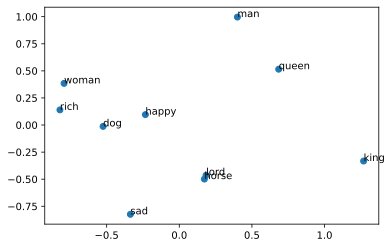

In [26]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

As we can see that **woman and queen are next to each other**. However, we have to be careful with the interpretation of this projected word vectors, since the PCA depends on the projection -- as shown in the following illustration.

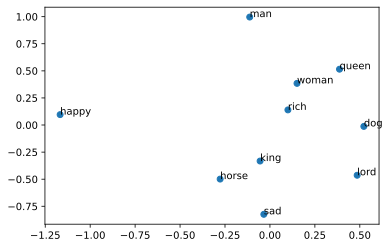

In [27]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()

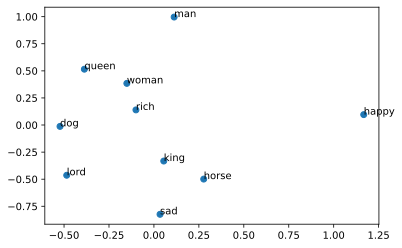

In [28]:
result= compute_pca(X, 10)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()